# Melanoma Detection Assignment

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion


In [1]:
#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#unziping dataset
!unzip "gdrive/My Drive/Cancer Study/CNN_assignment.zip"> /dev/null

In [3]:
#import libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [4]:
#path of of train and test dataset
data_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
#size of train dataset
Img_cnt_train = len(list(data_train.glob('*/*.jpg')))
print(Img_cnt_train)
#size of test dataset
Img_cnt_test = len(list(data_test.glob('*/*.jpg')))
print(Img_cnt_test)

2239
118


### **Creating dataset**

Defining parameters for the loader:

Using 80% of the images for training, and 20% for validation.

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
# Resizing image height and width for training dataset and using seed 123
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Resizing image height and width for validation dataset and using seed 123
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
#class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Visualizing the data**

Visualizing one instance of all the nine classes present in the dataset

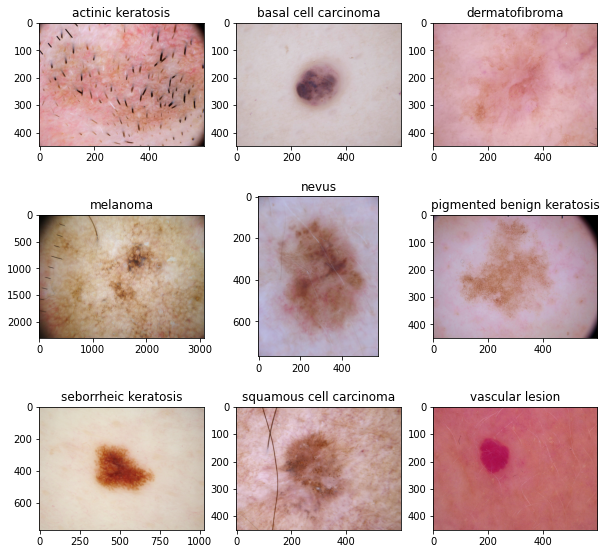

In [10]:
#plotting image in the dataset
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

**Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]**

In [12]:
#importing libraries
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

#model building
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

## **Compiling the model**

Using adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### **Training the model**

In [14]:
#running model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 30s 129ms/step - loss: 2.0623 - accuracy: 0.1970 - val_loss: 2.0557 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 80ms/step - loss: 2.0189 - accuracy: 0.2204 - val_loss: 2.0315 - val_accuracy: 0.2103
Epoch 3/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0225 - accuracy: 0.1959 - val_loss: 1.9937 - val_accuracy: 0.2371
Epoch 4/20
56/56 [==============================] - 4s 76ms/step - loss: 1.9830 - accuracy: 0.2165 - val_loss: 2.0310 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0117 - accuracy: 0.2160 - val_loss: 2.0160 - val_accuracy: 0.2438
Epoch 6/20
56/56 [==============================] - 4s 76ms/step - loss: 1.9078 - accuracy: 0.2768 - val_loss: 1.8646 - val_accuracy: 0.3400
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.8348 - accuracy: 0.3225 - val_loss: 1.8247 - val_accuracy: 0.3199
Epoch 8/20
56/56 [====

**Visualizing training results**

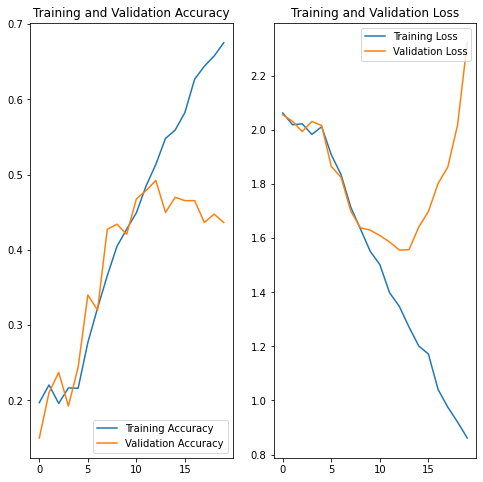

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations from first base model:**

The model is overfitting as there is difference in loss functions in training & test

The accuracy is around 67% because there are enough features to remember pattern.

In [16]:
# data augmentation 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

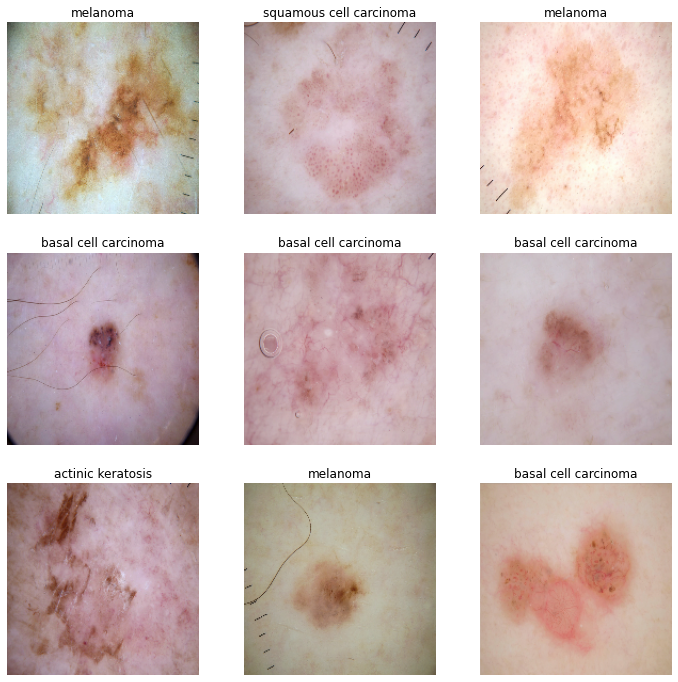

In [17]:
#Visualizing augmentation strategy for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
#model building
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [19]:
#modle Compiling
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
#training model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 7s 92ms/step - loss: 2.0430 - accuracy: 0.2204 - val_loss: 1.9364 - val_accuracy: 0.2595
Epoch 2/20
56/56 [==============================] - 5s 87ms/step - loss: 1.9020 - accuracy: 0.2779 - val_loss: 1.9379 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 5s 87ms/step - loss: 1.8103 - accuracy: 0.3220 - val_loss: 1.9253 - val_accuracy: 0.2819
Epoch 4/20
56/56 [==============================] - 5s 87ms/step - loss: 1.7482 - accuracy: 0.3583 - val_loss: 1.6442 - val_accuracy: 0.4362
Epoch 5/20
56/56 [==============================] - 5s 88ms/step - loss: 1.7329 - accuracy: 0.3661 - val_loss: 1.6669 - val_accuracy: 0.4004
Epoch 6/20
56/56 [==============================] - 5s 87ms/step - loss: 1.6043 - accuracy: 0.4219 - val_loss: 1.5881 - val_accuracy: 0.4362
Epoch 7/20
56/56 [==============================] - 5s 87ms/step - loss: 1.5668 - accuracy: 0.4325 - val_loss: 1.5586 - val_accuracy: 0.4676
Epoch 8/20
56/56 [======

**Visualizing results**

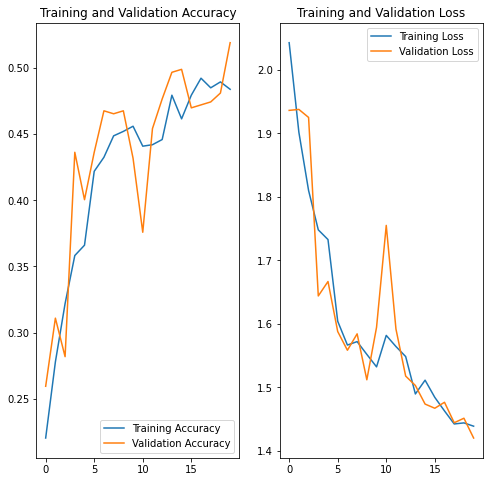

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations from Second Model:**

There is no improvement in accuracy but the overfitting problem has been solved due to data augmentation

The model accuracy could be increased by using more epochs

**Finding the distribution of classes in the training dataset.**

In [22]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


<BarContainer object of 9 artists>

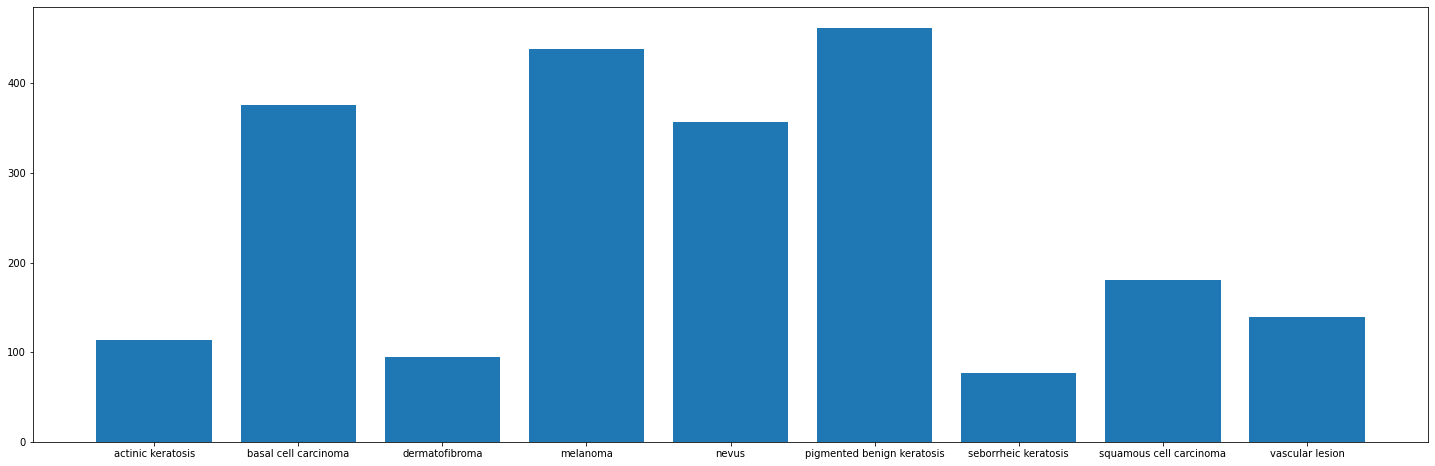

In [23]:
#plotting bar graph
count=[]
for i in class_names:
    count.append(len(list(data_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,8))
plt.bar(class_names,count)

**Observations:**

squamous cell carcinoma has least number of samples

actinic keratosis and dermatofibroma have proportionate number of classes. melanoma and pigmented benign keratosis have proprtionate number of classes

**Solving Class Imbalance**

There is class imbalance, to solve this python package Augmentor is used to add more samples across all classes so that none of the classes have less no. of samples.

In [24]:
#installing augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
#importing augmentor 
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBAE5689410>: 100%|██████████| 500/500 [00:18<00:00, 27.37 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAE4243FD0>: 100%|██████████| 500/500 [00:20<00:00, 24.97 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBAE5734450>: 100%|██████████| 500/500 [00:20<00:00, 24.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FBAE56E3410>: 100%|██████████| 500/500 [01:27<00:00,  5.72 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FBAE59D3310>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAE067D810>: 100%|██████████| 500/500 [00:16<00:00, 30.86 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FBAE1F9EA50>: 100%|██████████| 500/500 [00:39<00:00, 12.73 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBB774B9E90>: 100%|██████████| 500/500 [00:16<00:00, 30.71 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBAE4077110>: 100%|██████████| 500/500 [00:16<00:00, 30.72 Samples/s]


In [26]:
#Count of total number of images generated by Augmentor.
image_count_train = len(list(data_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Model Building

In [27]:
# training dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [28]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [29]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
#Dataset.cache(): keeps the images in memory after they're loaded off disk during the first epoch.
#Dataset.prefetch():overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
#CNN Model Architecture

#Sequential allows to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#1st Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#2nd Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#3rd Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 128)      

In [31]:
#Compiling Model
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [32]:
# Training model
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
168/169 [============================>.] - ETA: 0s - loss: 1.8136 - accuracy: 0.2989
Epoch 1: val_accuracy improved from -inf to 0.46993, saving model to model.h5
169/169 [==============================] - 37s 66ms/step - loss: 1.8125 - accuracy: 0.2995 - val_loss: 1.5236 - val_accuracy: 0.4699
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.5354 - accuracy: 0.4301
Epoch 2: val_accuracy improved from 0.46993 to 0.51076, saving model to model.h5
169/169 [==============================] - 7s 40ms/step - loss: 1.5354 - accuracy: 0.4301 - val_loss: 1.3166 - val_accuracy: 0.5108
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.3730 - accuracy: 0.4846
Epoch 3: val_accuracy improved from 0.51076 to 0.54120, saving model to model.h5
169/169 [==============================] - 7s 42ms/step - loss: 1.3730 - accuracy: 0.4846 - val_loss: 1.2496 - val_accuracy: 0.5412
Epoch 4/30
168/169 [============================>.] - ETA: 0s - loss: 1.246

Model stopped epoch as the metrics stopped improving

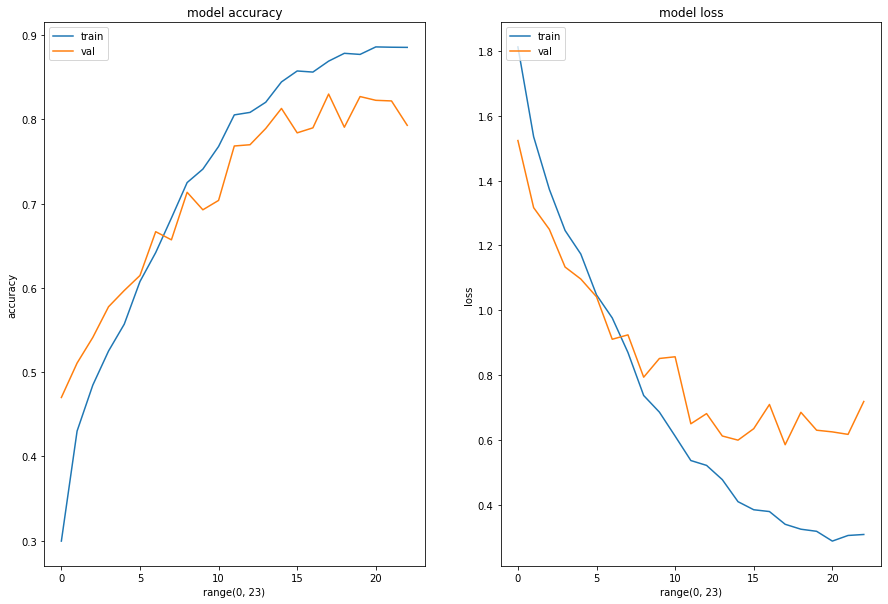

In [33]:
# Ploting training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Ploting Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Ploting Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


**Observations from final model:**

The accuracy is around 88%

### **Model Prediction**

Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


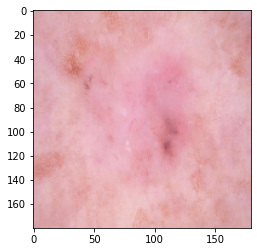

In [34]:
#importing module
from glob import glob

Test_image_path = os.path.join(data_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

The model has correctly predicted the class